# Interpretable AI for Deep Learning Models
###### ARI3205-SEM1-A-2526
### Proffessor: Konstantinos Makantasis
##### Authors: Love Carlander Strandang (2513558), Edvin Sanfridsson (2515058)



# 0.0 Setup

This section contains:
- Imports + environment info
- Reproducibility (seeds)
- Generic training loops (tabular + vision)
- Metrics + plotting utilities
- Model definitions (Tabular NN + CNN)
- Small wrappers to make PyTorch models compatible with interpretability libraries

## 0.1 Setup and Imports
### 0.1.1 Imports

In [1]:
import json
import pickle
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, accuracy_score, mean_absolute_error


### 0.1.2 Reproducibility 
We set a seed for random so that we will get cosistent reproducable results

In [2]:
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

### 0.1.3 Setup Root Repo

In [3]:
current_working_directory = Path.cwd()
repo_root_directory = current_working_directory.parent

if str(repo_root_directory) not in sys.path:
    sys.path.insert(0, str(repo_root_directory))

print("Repo root added to sys.path:", repo_root_directory)

artifacts_root_directory = repo_root_directory / "artifacts"

adult_artifacts_directory = artifacts_root_directory / "train_all" / "adult_mlp"
california_artifacts_directory = artifacts_root_directory / "train_all" / "california_mlp"
fashion_artifacts_directory = artifacts_root_directory / "train_all" / "fashion_cnn"

print("CWD:", current_working_directory)
print("Repo root:", repo_root_directory)
print("Artifacts root exists?", artifacts_root_directory.exists())
print("Adult artifacts exists?", adult_artifacts_directory.exists())
print("California artifacts exists?", california_artifacts_directory.exists())
print("Fashion artifacts exists?", fashion_artifacts_directory.exists())



Repo root added to sys.path: /Users/robin.carlander/Malta Courses/Interpretable AI/Interpretable Project/Interpertable-AI-for-Deep-Learning-Models
CWD: /Users/robin.carlander/Malta Courses/Interpretable AI/Interpretable Project/Interpertable-AI-for-Deep-Learning-Models/notebooks
Repo root: /Users/robin.carlander/Malta Courses/Interpretable AI/Interpretable Project/Interpertable-AI-for-Deep-Learning-Models
Artifacts root exists? True
Adult artifacts exists? True
California artifacts exists? True
Fashion artifacts exists? True


## 0.2 Load Trained Models

### 0.2.1 Adult
We have trained the

In [4]:
import tensorflow as tf
from tensorflow import keras

adult_model_path = adult_artifacts_directory / "best_model.keras"
adult_preprocessor_path = adult_artifacts_directory / "preprocessing.pkl"
adult_feature_names_path = adult_artifacts_directory / "expanded_feature_names.json"

adult_model = keras.models.load_model(adult_model_path)

with open(adult_preprocessor_path, "rb") as file_handle:
    adult_preprocessor = pickle.load(file_handle)

adult_expanded_feature_names = json.loads(adult_feature_names_path.read_text())

/Users/robin.carlander/Malta Courses/Interpretable AI/Interpretable Project/Interpertable-AI-for-Deep-Learning-Models/.venv311/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


#### Prediction Wrappers

In [5]:
def predict_adult_positive_probability(features_dataframe: pd.DataFrame) -> np.ndarray:
    processed_features = adult_preprocessor.transform(features_dataframe)
    probability = adult_model.predict(processed_features, verbose=0).reshape(-1)
    return probability

def predict_adult_label(features_dataframe: pd.DataFrame, threshold: float = 0.5) -> np.ndarray:
    probability = predict_adult_positive_probability(features_dataframe)
    return (probability >= threshold).astype(int)

def predict_adult_probability_matrix(features_dataframe: pd.DataFrame) -> np.ndarray:
    """Return (n,2) probabilities for [<=50K, >50K]."""
    positive_probability_vector = predict_adult_positive_probability(features_dataframe)
    positive_probability_vector = np.clip(positive_probability_vector, 1e-7, 1.0 - 1e-7)
    negative_probability_vector = 1.0 - positive_probability_vector
    return np.column_stack([negative_probability_vector, positive_probability_vector])


### 0.2.2 California (Keras regressor + numeric preprocessor)

In [6]:
california_model_path = california_artifacts_directory / "best_model.keras"
california_preprocessor_path = california_artifacts_directory / "preprocessing.pkl"
california_feature_names_path = california_artifacts_directory / "feature_names.json"

california_model = keras.models.load_model(california_model_path)

with open(california_preprocessor_path, "rb") as file_handle:
    california_preprocessor = pickle.load(file_handle)

california_feature_names = json.loads(california_feature_names_path.read_text())


In [7]:
def predict_california_value(features_dataframe: pd.DataFrame) -> np.ndarray:
    processed_features = california_preprocessor.transform(features_dataframe)
    prediction = california_model.predict(processed_features, verbose=0).reshape(-1)
    return prediction


### 2.3 Fashion CNN (PyTorch)

In [8]:
import torch
from src.models.fashion_cnn import FashionCNN  # your class
from src.data.fashion import load_fashion, FASHION_MNIST_CLASS_NAMES

fashion_weights_path = fashion_artifacts_directory / "best_model.pt"

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

fashion_model = FashionCNN(class_count=len(FASHION_MNIST_CLASS_NAMES)).to(device)
fashion_model.load_state_dict(torch.load(fashion_weights_path, map_location=device))
fashion_model.eval();

fashion_train_dataset, fashion_test_dataset = load_fashion(normalize=False)  # match your training choice

## 0.3 Load test splits

### 0.3.1 Adult splits

In [9]:
from src.data.adult import load_adult_splits

adult_train_df, adult_val_df, adult_test_df, y_train, y_val, y_test, adult_meta = load_adult_splits(
    random_state=RANDOM_SEED
)

### 0.3.2 Calefornia Splits

In [10]:
from src.data.california import load_california

cal_train_df, cal_val_df, cal_test_df, cal_y_train, cal_y_val, cal_y_test = load_california(
    random_state=RANDOM_SEED
)

### 0.3.3 Sanity check

In [11]:
adult_test_probs = predict_adult_positive_probability(adult_test_df)
adult_test_pred = (adult_test_probs >= 0.5).astype(int)
print("Adult test accuracy:", accuracy_score(y_test, adult_test_pred))
print("Adult test AUC:", roc_auc_score(y_test, adult_test_probs))

cal_test_pred = predict_california_value(cal_test_df)
print("California test MAE:", mean_absolute_error(cal_y_test, cal_test_pred))

Adult test accuracy: 0.8609888422561163
Adult test AUC: 0.9218229726601357
California test MAE: 0.35739303559150115


# Part 2 — Local Interpretability Techniques (Adult Census Income)

In this part we explain individual predictions of the **Adult Census Income** feed-forward neural network trained in Part 1.  
The model outputs a probability for the positive class **P(>50K)** (income > \$50K). We apply three local explanation methods:

- **LIME**: fits a simple interpretable surrogate model around one instance.
- **SHAP**: attributes the prediction to features using Shapley-value based additive contributions.
- **Anchors**: produces an IF–THEN rule that “anchors” the prediction with high precision.

Because the neural network was trained on **preprocessed inputs** (scaled numeric features + one-hot encoded categorical features), explanations are produced in the **expanded feature space**. For one-hot features, terms like `workclass=Private` mean that the corresponding indicator feature is 1 (present), while “not present” indicators may appear as well. This can sometimes look unintuitive, but it reflects the actual model input representation.


In [12]:
# Reuse everything already loaded in Setup (Section 0)

adult_random_seed_value = RANDOM_SEED
np.random.seed(adult_random_seed_value)

# Reuse Adult dataset splits (already loaded in Setup)
adult_train_features_dataframe = adult_train_df
adult_validation_features_dataframe = adult_val_df
adult_test_features_dataframe = adult_test_df

adult_train_labels_array = y_train
adult_validation_labels_array = y_val
adult_test_labels_array = y_test

adult_metadata_dict = adult_meta

adult_original_feature_name_list = list(adult_metadata_dict["feature_names"])
adult_class_name_list = list(adult_metadata_dict["class_names"])

print("Adult train shape:", adult_train_features_dataframe.shape)
print("Adult test shape:", adult_test_features_dataframe.shape)
print("Adult class names:", adult_class_name_list)

# Reuse trained model + preprocessing artifacts (already loaded in Setup)
adult_trained_keras_model = adult_model
adult_trained_preprocessor = adult_preprocessor
adult_expanded_feature_name_list = adult_expanded_feature_names

print("Expanded feature count (after one-hot):", len(adult_expanded_feature_name_list))


Adult train shape: (31258, 14)
Adult test shape: (9769, 14)
Adult class names: ['<=50K', '>50K']
Expanded feature count (after one-hot): 105


In [13]:
def adult_predict_probability_matrix_from_raw_dataframe(
    raw_features_dataframe: pd.DataFrame,
) -> np.ndarray:
    """
    Return probabilities shaped (n_samples, 2):
      [:, 0] = P(<=50K)
      [:, 1] = P(>50K)

    Reuses Setup-loaded: adult_trained_preprocessor, adult_trained_keras_model,
    and adult_original_feature_name_list.
    """
    ordered_raw_features_dataframe = raw_features_dataframe[adult_original_feature_name_list].copy()

    processed_feature_matrix = adult_trained_preprocessor.transform(ordered_raw_features_dataframe)
    processed_feature_matrix = np.asarray(processed_feature_matrix)

    positive_class_probability_vector = adult_trained_keras_model.predict(
        processed_feature_matrix, verbose=0
    ).reshape(-1, 1)

    positive_class_probability_vector = np.clip(
        positive_class_probability_vector, 1e-7, 1.0 - 1e-7
    )

    negative_class_probability_vector = 1.0 - positive_class_probability_vector
    probability_matrix = np.concatenate(
        [negative_class_probability_vector, positive_class_probability_vector], axis=1
    )
    return probability_matrix


def adult_predict_probability_matrix_from_processed_matrix(
    processed_feature_matrix: np.ndarray,
) -> np.ndarray:
    """
    Same as above, but expects inputs already preprocessed (one-hot + scaled).
    """
    positive_class_probability_vector = adult_trained_keras_model.predict(
        processed_feature_matrix, verbose=0
    ).reshape(-1, 1)

    positive_class_probability_vector = np.clip(
        positive_class_probability_vector, 1e-7, 1.0 - 1e-7
    )

    negative_class_probability_vector = 1.0 - positive_class_probability_vector
    probability_matrix = np.concatenate(
        [negative_class_probability_vector, positive_class_probability_vector], axis=1
    )
    return probability_matrix


def adult_predict_label_vector_from_raw_dataframe(
    raw_features_dataframe: pd.DataFrame,
    decision_threshold: float = 0.5,
) -> np.ndarray:
    """
    Predict class labels (0/1) using the raw dataframe.
    """
    probability_matrix = adult_predict_probability_matrix_from_raw_dataframe(raw_features_dataframe)
    positive_class_probability_vector = probability_matrix[:, 1]
    predicted_label_vector = (positive_class_probability_vector >= decision_threshold).astype(int)
    return predicted_label_vector


In [14]:
from IPython.display import display
import numpy as np

# Precompute the exact model input matrices once (this is what LIME/SHAP/Anchors will use)
adult_train_processed_feature_matrix = np.asarray(
    adult_trained_preprocessor.transform(
        adult_train_features_dataframe[adult_original_feature_name_list]
    )
)

adult_test_processed_feature_matrix = np.asarray(
    adult_trained_preprocessor.transform(
        adult_test_features_dataframe[adult_original_feature_name_list]
    )
)

# Model probabilities + predicted labels on the test set (in processed feature space)
adult_test_probability_matrix = adult_predict_probability_matrix_from_processed_matrix(
    adult_test_processed_feature_matrix
)

adult_test_predicted_label_vector = np.argmax(adult_test_probability_matrix, axis=1)
adult_test_labels_array = np.asarray(adult_test_labels_array).astype(int)

adult_test_accuracy_value = float(
    np.mean(adult_test_predicted_label_vector == adult_test_labels_array)
)

# Case selection indices
adult_incorrect_prediction_index_vector = np.where(
    adult_test_predicted_label_vector != adult_test_labels_array
)[0]

adult_correct_positive_index_vector = np.where(
    (adult_test_predicted_label_vector == 1) & (adult_test_labels_array == 1)
)[0]

adult_correct_negative_index_vector = np.where(
    (adult_test_predicted_label_vector == 0) & (adult_test_labels_array == 0)
)[0]

print("Adult test accuracy:", adult_test_accuracy_value)
print("Incorrect predictions:", len(adult_incorrect_prediction_index_vector))

adult_case_name_to_row_index: dict[str, int | None] = {
    "correct_positive_example": int(adult_correct_positive_index_vector[0]) if len(adult_correct_positive_index_vector) else None,
    "correct_negative_example": int(adult_correct_negative_index_vector[0]) if len(adult_correct_negative_index_vector) else None,
    "incorrect_example_1": int(adult_incorrect_prediction_index_vector[0]) if len(adult_incorrect_prediction_index_vector) else None,
    "incorrect_example_2": int(adult_incorrect_prediction_index_vector[1]) if len(adult_incorrect_prediction_index_vector) > 1 else None,
}

adult_case_name_to_row_index


def display_adult_case_summary(case_label: str, test_row_index: int) -> None:
    selected_row_dataframe = adult_test_features_dataframe.iloc[[test_row_index]][adult_original_feature_name_list]
    selected_probability_vector = adult_predict_probability_matrix_from_raw_dataframe(selected_row_dataframe)[0]

    true_label_value = int(adult_test_labels_array[test_row_index])
    predicted_label_value = int(np.argmax(selected_probability_vector))
    predicted_positive_probability_value = float(selected_probability_vector[1])

    print(
        f"{case_label} | row_index={test_row_index} | true={true_label_value} | "
        f"pred={predicted_label_value} | P(>50K)={predicted_positive_probability_value:.3f}"
    )
    display(selected_row_dataframe)


for case_label, test_row_index in adult_case_name_to_row_index.items():
    if test_row_index is not None:
        display_adult_case_summary(case_label, test_row_index)


Adult test accuracy: 0.8609888422561163
Incorrect predictions: 1358
correct_positive_example | row_index=12 | true=1 | pred=1 | P(>50K)=0.941


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
635,41,State-gov,253250,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,7298,0,40,United-States


correct_negative_example | row_index=0 | true=0 | pred=0 | P(>50K)=0.007


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
24799,29,Private,229729,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,Male,0,0,40,United-States


incorrect_example_1 | row_index=1 | true=1 | pred=0 | P(>50K)=0.395


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
7034,54,Private,81859,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States


incorrect_example_2 | row_index=6 | true=0 | pred=1 | P(>50K)=0.669


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
11878,50,Private,138944,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States


## Selected test instances (2 correct + 2 incorrect)

We select four test instances to explain: two correctly predicted and two misclassified.

- **Correct positive** (`row_index=12`): true=1, pred=1, **P(>50K)=0.941**
- **Correct negative** (`row_index=0`): true=0, pred=0, **P(>50K)=0.007**
- **Incorrect #1** (`row_index=1`): true=1, pred=0, **P(>50K)=0.395**
- **Incorrect #2** (`row_index=6`): true=0, pred=1, **P(>50K)=0.669**

Overall test performance for the Adult model is **accuracy ≈ 0.861** with **1358 incorrect predictions** on the test split. The goal here is not to improve accuracy, but to understand *why the model makes specific decisions*, especially for errors.

In [15]:
import re
import pandas as pd

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 140)
pd.set_option("display.max_colwidth", 60)

one_hot_prefix_list = [
    "workclass",
    "education",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native_country",
]

numeric_feature_name_set = {
    "education_num",  # IMPORTANT: avoid turning this into "education=num"
}

def prettify_one_hot_feature_name(feature_name: str) -> str:
    # Keep numeric features intact
    if feature_name in numeric_feature_name_set:
        return feature_name

    for prefix in one_hot_prefix_list:
        prefix_with_underscore = prefix + "_"
        if feature_name.startswith(prefix_with_underscore):
            return feature_name.replace(prefix_with_underscore, prefix + "=", 1)
    return feature_name


def prettify_lime_term(lime_term_text: str) -> str:
    """
    Convert one-hot threshold terms like:
      native_country_Cambodia <= 0.00  -> native_country != Cambodia
      relationship_Husband > 0.00     -> relationship = Husband
    """
    match = re.match(
        r"^([A-Za-z0-9_\-\(\)]+)_([A-Za-z0-9_\-\(\)&\.\s]+)\s*(<=|>)\s*0\.00$",
        lime_term_text,
    )
    if match:
        prefix, category, operator = match.groups()
        if prefix in one_hot_prefix_list:
            if operator == "<=":
                return f"{prefix} != {category}"
            return f"{prefix} = {category}"
    return lime_term_text


def print_compact_dataframe(dataframe: pd.DataFrame, max_rows: int = 12) -> None:
    compact_df = dataframe.head(max_rows).copy()
    if "feature_name" in compact_df.columns:
        compact_df["feature_name"] = compact_df["feature_name"].astype(str).apply(prettify_one_hot_feature_name)
    print(compact_df.to_string(index=False))


## 2.1 LIME (Local Interpretable Model-Agnostic Explanations)

**How LIME works.**  
LIME explains one prediction by generating many **perturbed samples** around the chosen instance, weighting them by similarity (distance) to the original instance, and fitting a **simple interpretable model** (typically a sparse linear model) on this locally weighted dataset. The fitted surrogate approximates the neural network’s **local decision boundary** near the instance.

**How to interpret the output.**  
LIME returns feature conditions with **weights**:
- Positive weight → pushes prediction toward the positive class **>50K**
- Negative weight → pushes prediction toward the negative class **<=50K**

A key limitation is that LIME is only guaranteed to be faithful **locally**, and explanation stability depends on sampling and discretization. We report the surrogate fidelity using the local **R² score** (moderate values suggest the boundary is not perfectly linear locally).


--- LIME explanation for: correct_positive_example ---
True label: 1
Pred label: 1
P(>50K): 0.9406070709228516
Local surrogate fidelity (R^2): 0.54799905586744

Top local contributions (filtered: one-hot presence + numeric) (feature -> weight):
  capital_gain > -0.14                                    +0.6489
  capital_loss <= -0.22                                   -0.1568
  hours_per_week <= -0.04                                 -0.1037


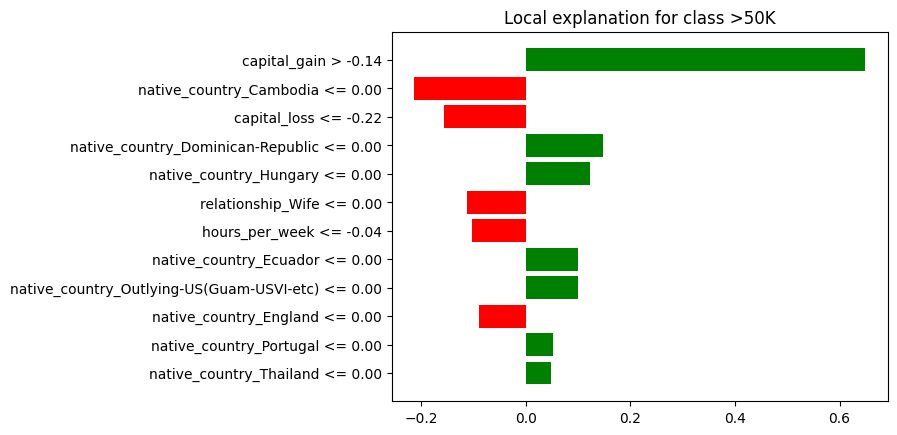


--- LIME explanation for: correct_negative_example ---
True label: 0
Pred label: 0
P(>50K): 0.007470519281923771
Local surrogate fidelity (R^2): 0.5653905855816744

Top local contributions (filtered: one-hot presence + numeric) (feature -> weight):
  capital_gain <= -0.14                                   -0.6724
  capital_loss <= -0.22                                   -0.1603


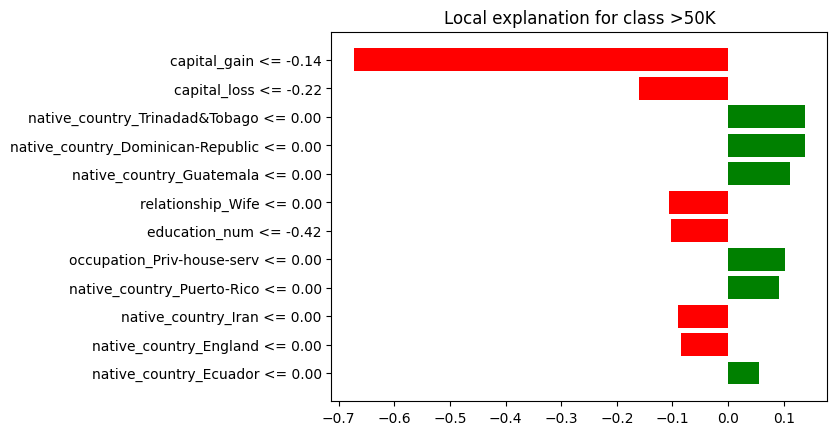


--- LIME explanation for: incorrect_example_1 ---
True label: 1
Pred label: 0
P(>50K): 0.3951988220214844
Local surrogate fidelity (R^2): 0.4921613251138036

Top local contributions (filtered: one-hot presence + numeric) (feature -> weight):
  capital_gain <= -0.14                                   -0.6479
  capital_loss <= -0.22                                   -0.1396


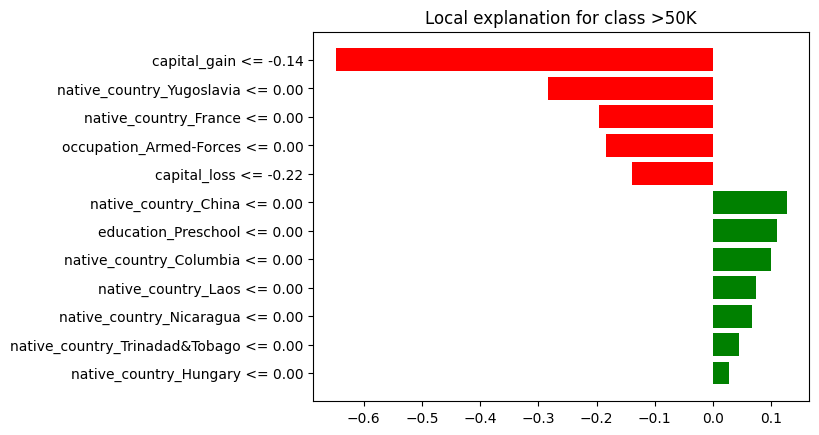


--- LIME explanation for: incorrect_example_2 ---
True label: 0
Pred label: 1
P(>50K): 0.6685057878494263
Local surrogate fidelity (R^2): 0.5131388386973226

Top local contributions (filtered: one-hot presence + numeric) (feature -> weight):
  capital_gain <= -0.14                                   -0.6475
  capital_loss <= -0.22                                   -0.1715


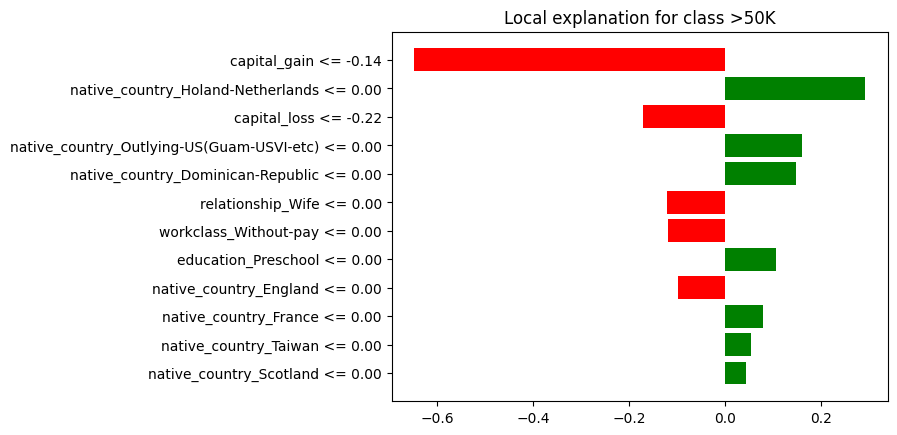

In [16]:
import matplotlib.pyplot as plt
import re
from lime.lime_tabular import LimeTabularExplainer

# LIME explainer (works in processed feature space)
lime_explainer_instance = LimeTabularExplainer(
    training_data=adult_train_processed_feature_matrix,
    feature_names=adult_expanded_feature_name_list,
    class_names=adult_class_name_list,
    mode="classification",
    discretize_continuous=True,
    random_state=adult_random_seed_value,
)

lime_case_name_to_feature_weight_list: dict[str, list[tuple[str, float]]] = {}

# Helper functions to filter noisy one-hot "absence" terms
# Keep: numeric/discretized terms + one-hot PRESENCE terms ("> 0.00")
# Drop: one-hot ABSENCE terms ("<= 0.00") like native_country_X <= 0.00
def lime_term_is_one_hot_feature(term_text: str) -> bool:
    term_text = term_text.strip()
    return any(term_text.startswith(prefix + "_") for prefix in one_hot_prefix_list)

def lime_term_is_presence_indicator(term_text: str) -> bool:
    return bool(re.search(r">\s*0\.00$", term_text.strip()))

def run_lime_explanation_for_case(
    case_label: str,
    test_row_index: int,
    shown_feature_count: int = 12,
) -> None:
    lime_explanation_object = lime_explainer_instance.explain_instance(
        data_row=adult_test_processed_feature_matrix[test_row_index],
        predict_fn=adult_predict_probability_matrix_from_processed_matrix,
        num_features=shown_feature_count,
    )

    probability_vector = adult_test_probability_matrix[test_row_index]
    print(f"\n--- LIME explanation for: {case_label} ---")
    print("True label:", int(adult_test_labels_array[test_row_index]))
    print("Pred label:", int(adult_test_predicted_label_vector[test_row_index]))
    print("P(>50K):", float(probability_vector[1]))
    print("Local surrogate fidelity (R^2):", float(lime_explanation_object.score))

    # Save raw list for completeness / reproducibility
    raw_feature_weight_list = lime_explanation_object.as_list()
    lime_case_name_to_feature_weight_list[case_label] = raw_feature_weight_list

    # Filter: keep continuous terms + one-hot presence indicators only
    filtered_feature_weight_list: list[tuple[str, float]] = []
    for term_text, weight_value in raw_feature_weight_list:
        if lime_term_is_one_hot_feature(term_text):
            if lime_term_is_presence_indicator(term_text):
                filtered_feature_weight_list.append((term_text, weight_value))
            else:
                # Drop one-hot absence indicators (<= 0.00) and other one-hot oddities
                continue
        else:
            # Numeric/discretized feature (e.g., capital_gain > -0.14)
            filtered_feature_weight_list.append((term_text, weight_value))

    # Prettify terms after filtering
    pretty_feature_weight_list = [
        (prettify_lime_term(term_text), weight_value)
        for term_text, weight_value in filtered_feature_weight_list
    ]

    print("\nTop local contributions (filtered: one-hot presence + numeric) (feature -> weight):")
    for feature_text, weight_value in pretty_feature_weight_list:
        print(f"  {feature_text:<55} {weight_value:+.4f}")

    lime_figure = lime_explanation_object.as_pyplot_figure(label=1)
    plt.show()


for case_label, test_row_index in adult_case_name_to_row_index.items():
    if test_row_index is not None:
        run_lime_explanation_for_case(case_label, test_row_index)


### LIME results and interpretation

**Note on presentation.**  
Because the model input is a high-dimensional one-hot + scaled feature space, raw LIME often surfaces many one-hot “absence” terms (e.g., `native_country_X <= 0.00`). In this notebook we **filter** the displayed LIME terms to keep **numeric/discretized features** and **one-hot presence indicators** only (terms ending with `> 0.00`). In our four selected cases, the strongest displayed drivers are therefore numeric.

#### (A) Correct positive (row 12, P(>50K)=0.941)
The explanation is dominated by a strong positive contribution from **capital_gain > -0.14** (weight = **+0.6489**), pushing strongly toward **>50K**.  
Other numeric terms reduce the score locally (e.g., **capital_loss <= -0.22** with **−0.1568**, and **hours_per_week <= -0.04** with **−0.1037**), but capital_gain is clearly the strongest local signal.

Local surrogate fidelity is moderate (**R² = 0.5480**), indicating the model’s local behavior is not perfectly linear, but still reasonably approximated by a simple surrogate in this neighborhood.

#### (B) Correct negative (row 0, P(>50K)=0.007)
For the negative case, the strongest signal is **capital_gain <= -0.14** (weight = **−0.6724**), strongly pushing toward **<=50K**.  
A second strong negative numeric term is **capital_loss <= -0.22** (weight = **−0.1603**).

Local fidelity is again moderate (**R² = 0.5654**). Overall, LIME suggests the model treats low/absent capital signals as strong evidence for <=50K in this local region.

#### (C) Incorrect #1 (row 1, true=1 but pred=0, P(>50K)=0.395)
This false negative is driven mainly by **capital_gain <= -0.14** (weight = **−0.6479**), pushing the model toward predicting **<=50K** despite the true label being >50K.  
**capital_loss <= -0.22** also contributes negatively (**−0.1396**).

Fidelity is **R² = 0.4922**, lower than the correct cases, suggesting a more complex/nonlinear local region.

#### (D) Incorrect #2 (row 6, true=0 but pred=1, P(>50K)=0.669)
Even though the model predicts **>50K**, LIME shows strong negative numeric evidence:  
**capital_gain <= -0.14** (**−0.6475**) and **capital_loss <= -0.22** (**−0.1715**), which locally push toward **<=50K**.

This illustrates a key limitation: LIME is a *local linear approximation*. In this case, other features and interactions (revealed more clearly by SHAP/Anchors) can outweigh the negative capital signals in the actual model, leading to a positive prediction.

Fidelity is moderate (**R² = 0.5131**).

**Summary (LIME).**  
Across all four instances, **capital_gain** is consistently the highest-magnitude local driver, with **capital_loss** also contributing. The misclassified examples show that even when LIME highlights strong negative numeric evidence, the full model can still predict >50K due to other interacting factors not captured well by a simple local linear surrogate.


## 2.2 SHAP (Shapley Additive Explanations)

**How SHAP works.**  
SHAP explains a prediction by decomposing the model output into additive feature contributions based on **Shapley values** from cooperative game theory. For a chosen **background dataset** (baseline distribution), SHAP expresses the prediction as:

\[
f(x) \approx \mathbb{E}[f(X)] + \sum_{j=1}^{d} \phi_j
\]

Where:
- \(\mathbb{E}[f(X)]\) is the baseline prediction over background data,
- \(\phi_j\) is the SHAP value for feature \(j\).

**How to interpret the output.**
- Positive SHAP value → increases **P(>50K)**
- Negative SHAP value → decreases **P(>50K)**
- Larger absolute value → stronger influence

Compared to LIME, SHAP is typically more stable for a fixed background sample because it attributes contributions relative to a baseline rather than relying on local surrogate fitting with random perturbations.

/Users/robin.carlander/Malta Courses/Interpretable AI/Interpretable Project/Interpertable-AI-for-Deep-Learning-Models/.venv311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- SHAP explanation for: correct_positive_example ---
True label: 1
Pred label: 1
P(>50K): 0.9406070709228516


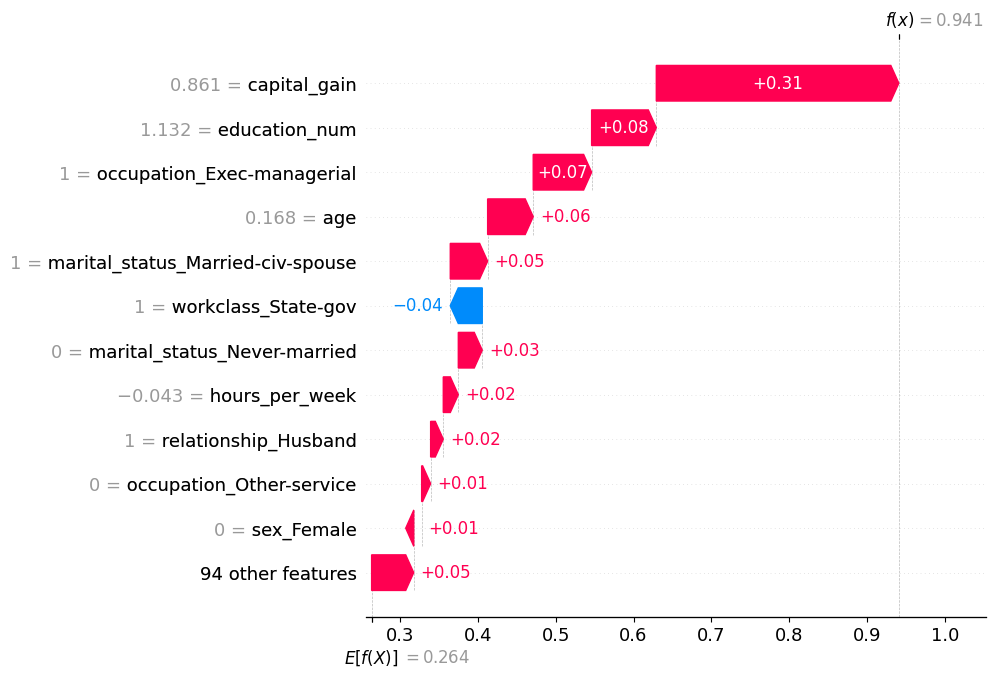


Top SHAP contributions (by absolute value):
                     feature_name  shap_value  absolute_shap_value
                     capital_gain    0.311402             0.311402
                    education_num    0.083050             0.083050
       occupation=Exec-managerial    0.074993             0.074993
                              age    0.058528             0.058528
marital_status=Married-civ-spouse    0.047972             0.047972
              workclass=State-gov   -0.041067             0.041067
     marital_status=Never-married    0.030752             0.030752
                   hours_per_week    0.019298             0.019298
             relationship=Husband    0.016230             0.016230
         occupation=Other-service    0.011548             0.011548

--- SHAP explanation for: correct_negative_example ---
True label: 0
Pred label: 0
P(>50K): 0.007470519281923771


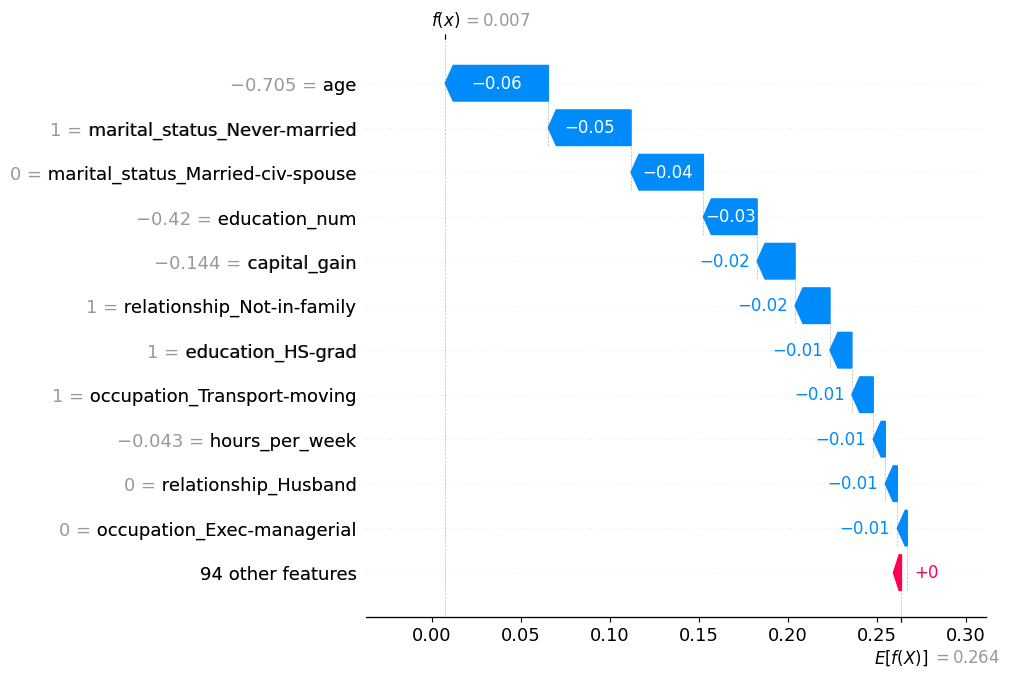


Top SHAP contributions (by absolute value):
                     feature_name  shap_value  absolute_shap_value
                              age   -0.057891             0.057891
     marital_status=Never-married   -0.046459             0.046459
marital_status=Married-civ-spouse   -0.040640             0.040640
                    education_num   -0.030155             0.030155
                     capital_gain   -0.021310             0.021310
       relationship=Not-in-family   -0.019611             0.019611
                education=HS-grad   -0.012287             0.012287
      occupation=Transport-moving   -0.011985             0.011985
                   hours_per_week   -0.006784             0.006784
             relationship=Husband   -0.006755             0.006755

--- SHAP explanation for: incorrect_example_1 ---
True label: 1
Pred label: 0
P(>50K): 0.3951988220214844


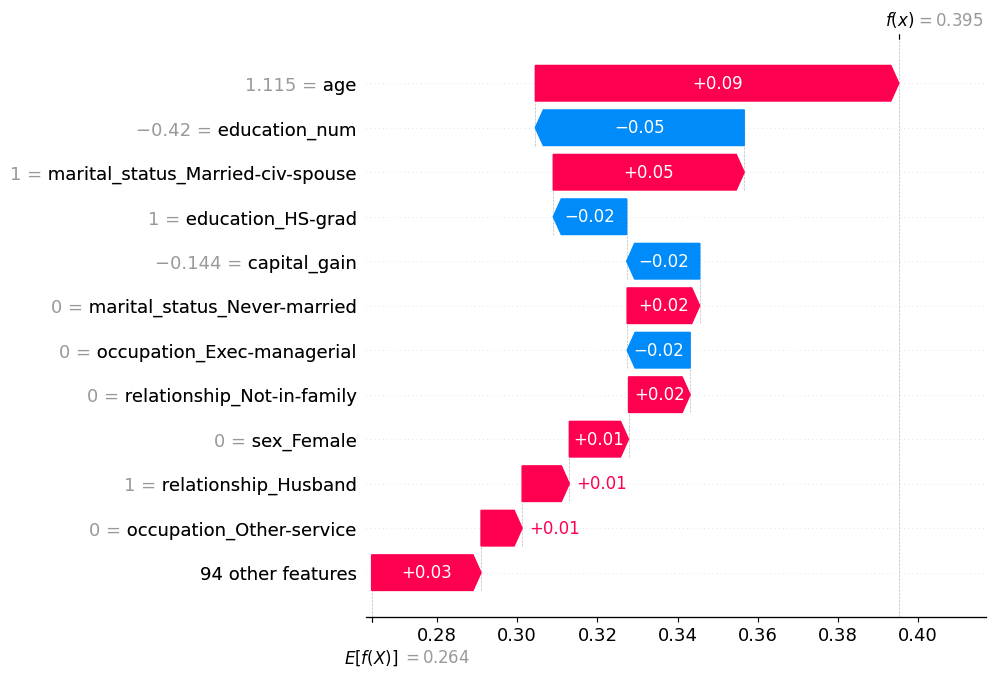


Top SHAP contributions (by absolute value):
                     feature_name  shap_value  absolute_shap_value
                              age    0.090689             0.090689
                    education_num   -0.052121             0.052121
marital_status=Married-civ-spouse    0.047646             0.047646
                education=HS-grad   -0.018313             0.018313
                     capital_gain   -0.018223             0.018223
     marital_status=Never-married    0.018111             0.018111
       occupation=Exec-managerial   -0.015722             0.015722
       relationship=Not-in-family    0.015373             0.015373
                       sex=Female    0.014766             0.014766
             relationship=Husband    0.011776             0.011776

--- SHAP explanation for: incorrect_example_2 ---
True label: 0
Pred label: 1
P(>50K): 0.6685057878494263


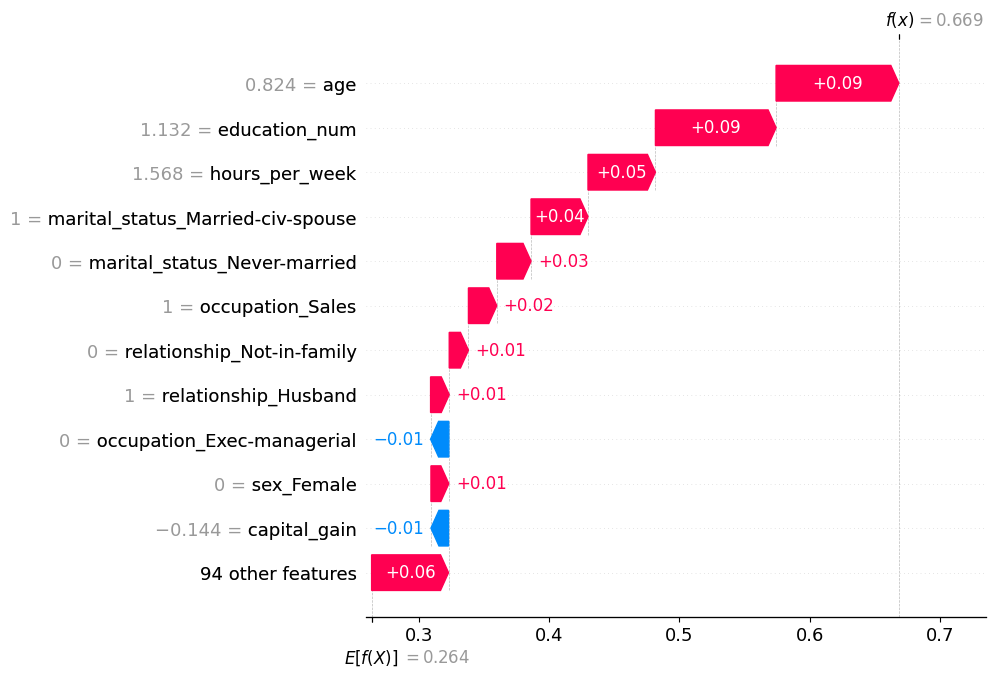


Top SHAP contributions (by absolute value):
                     feature_name  shap_value  absolute_shap_value
                              age    0.094257             0.094257
                    education_num    0.092643             0.092643
                   hours_per_week    0.051785             0.051785
marital_status=Married-civ-spouse    0.043734             0.043734
     marital_status=Never-married    0.026295             0.026295
                 occupation=Sales    0.021774             0.021774
       relationship=Not-in-family    0.014747             0.014747
             relationship=Husband    0.014318             0.014318
       occupation=Exec-managerial   -0.014000             0.014000
                       sex=Female    0.013716             0.013716


In [17]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# SHAP background (subset of training data in processed feature space)
shap_background_sample_size = 200
shap_background_row_indices = np.random.choice(
    adult_train_processed_feature_matrix.shape[0],
    size=min(shap_background_sample_size, adult_train_processed_feature_matrix.shape[0]),
    replace=False,
)
shap_background_processed_feature_matrix = adult_train_processed_feature_matrix[shap_background_row_indices]


def adult_predict_positive_probability_vector_from_processed_matrix(
    processed_feature_matrix: np.ndarray,
) -> np.ndarray:
    """Return P(>50K) for SHAP (shape: (n_samples,))."""
    probability_matrix = adult_predict_probability_matrix_from_processed_matrix(processed_feature_matrix)
    return probability_matrix[:, 1]


shap_masker_object = shap.maskers.Independent(shap_background_processed_feature_matrix)
shap_explainer_instance = shap.Explainer(
    adult_predict_positive_probability_vector_from_processed_matrix,
    shap_masker_object,
    feature_names=adult_expanded_feature_name_list,
    algorithm="permutation",
)

shap_case_name_to_top_feature_dataframe: dict[str, pd.DataFrame] = {}


def extract_top_shap_features_dataframe(
    shap_single_row_explanation: shap.Explanation,
    top_feature_count: int = 12,
) -> pd.DataFrame:
    shap_value_vector = np.asarray(shap_single_row_explanation.values).reshape(-1)
    feature_name_list = list(shap_single_row_explanation.feature_names)

    shap_summary_dataframe = pd.DataFrame(
        {
            "feature_name": feature_name_list,
            "shap_value": shap_value_vector,
            "absolute_shap_value": np.abs(shap_value_vector),
        }
    ).sort_values("absolute_shap_value", ascending=False)

    return shap_summary_dataframe.head(top_feature_count)


def run_shap_explanation_for_case(
    case_label: str,
    test_row_index: int,
    max_evaluations: int = 2000,
) -> None:
    shap_values_object = shap_explainer_instance(
        adult_test_processed_feature_matrix[test_row_index:test_row_index + 1],
        max_evals=max_evaluations,
    )

    probability_vector = adult_test_probability_matrix[test_row_index]
    print(f"\n--- SHAP explanation for: {case_label} ---")
    print("True label:", int(adult_test_labels_array[test_row_index]))
    print("Pred label:", int(adult_test_predicted_label_vector[test_row_index]))
    print("P(>50K):", float(probability_vector[1]))

    # Plot without relying on IPython display
    shap.plots.waterfall(shap_values_object[0], max_display=12, show=False)
    plt.show()

    top_feature_dataframe = extract_top_shap_features_dataframe(shap_values_object[0], top_feature_count=12)
    shap_case_name_to_top_feature_dataframe[case_label] = top_feature_dataframe

    print("\nTop SHAP contributions (by absolute value):")
    print_compact_dataframe(top_feature_dataframe, max_rows=10)


for case_label, test_row_index in adult_case_name_to_row_index.items():
    if test_row_index is not None:
        run_shap_explanation_for_case(case_label, test_row_index)


### SHAP results and interpretation

We explain the model’s **positive-class probability** \(P(>50K)\). Positive SHAP values increase \(P(>50K)\); negative values decrease it.

#### (A) Correct positive (row 12, P(>50K)=0.941)
The strongest SHAP contributor is **capital_gain** (**+0.311402**). Additional positive contributions include **education_num** (**+0.083050**), **occupation=Exec-managerial** (**+0.074993**), and **age** (**+0.058528**).  
The main negative contributor among the top features is **workclass=State-gov** (**−0.041067**), but it is outweighed by the strong positives. This aligns with a high-confidence >50K prediction.

#### (B) Correct negative (row 0, P(>50K)=0.007)
Key negative contributions are **age** (**−0.057891**), **marital_status=Never-married** (**−0.046459**), **marital_status=Married-civ-spouse** (**−0.040640**), **education_num** (**−0.030155**), and **capital_gain** (**−0.021310**).  
Together these reduce \(P(>50K)\), matching the model’s near-zero probability output.

#### (C) Incorrect #1 (row 1, true=1 but pred=0, P(>50K)=0.395)
The largest positive driver is **age** (**+0.090689**) and a strong additional positive is **marital_status=Married-civ-spouse** (**+0.047646**).  
However, **education_num** is strongly negative (**−0.052121**), and other negatives include **education=HS-grad** (**−0.018313**) and **capital_gain** (**−0.018223**).  
This indicates conflicting evidence: age/married push upward, but education/capital-related signals push downward enough to keep the probability below the 0.5 threshold, producing a false negative.

#### (D) Incorrect #2 (row 6, true=0 but pred=1, P(>50K)=0.669)
Strong positives include **age** (**+0.094257**), **education_num** (**+0.092643**), and **hours_per_week** (**+0.051785**), along with **marital_status=Married-civ-spouse** (**+0.043734**) and **occupation=Sales** (**+0.021774**).  
The strongest negative in the top list is **occupation=Exec-managerial** (**−0.014000**), which is too small to offset the positive push from age/education/hours. This suggests a shortcut-like pattern: “older + educated + works more (+ married)” is treated as strong evidence for >50K even when the true label is <=50K.

**Summary (SHAP).**  
SHAP repeatedly highlights **capital_gain, education_num, age, and hours_per_week** as key drivers. Compared to LIME, SHAP provides a more stable decomposition of the prediction into additive contributions relative to a background distribution.


## 2.3 Anchors

**How Anchors works.**  
Anchors generates a **rule-based explanation** for a single instance in the form of an IF–THEN rule:

> IF (conditions) THEN (prediction)

The explainer searches for a small set of conditions such that, when those conditions hold, the model’s prediction remains the same with high probability.

Anchors reports:
- **Precision:** how often the model keeps the same prediction when the rule holds
- **Coverage:** how frequently the rule applies in the data distribution

Unlike LIME/SHAP, which provide graded feature importance, Anchors focuses on producing a **compact, high-confidence rule** that “locks in” the prediction.


In [18]:
from alibi.explainers import AnchorTabular
import numpy as np

def adult_predict_label_vector_from_processed_matrix(
    processed_feature_matrix: np.ndarray,
) -> np.ndarray:
    """Predict class labels (0/1) from processed (one-hot + scaled) feature matrix."""
    probability_matrix = adult_predict_probability_matrix_from_processed_matrix(processed_feature_matrix)
    return np.argmax(probability_matrix, axis=1)


anchor_explainer_instance = AnchorTabular(
    predictor=adult_predict_label_vector_from_processed_matrix,
    feature_names=adult_expanded_feature_name_list,
)

# Discretization in processed feature space
anchor_explainer_instance.fit(
    adult_train_processed_feature_matrix,
    disc_perc=(25, 50, 75),
)

anchor_case_name_to_explanation_data: dict[str, dict] = {}

def run_anchor_explanation_for_case(
    case_label: str,
    test_row_index: int,
    required_precision_threshold: float = 0.95,
    fallback_precision_threshold: float = 0.90,
) -> None:
    probability_vector = adult_test_probability_matrix[test_row_index]

    print(f"\n--- Anchors explanation for: {case_label} ---")
    print("True label:", int(adult_test_labels_array[test_row_index]))
    print("Pred label:", int(adult_test_predicted_label_vector[test_row_index]))
    print("P(>50K):", float(probability_vector[1]))

    anchor_explanation_object = anchor_explainer_instance.explain(
        adult_test_processed_feature_matrix[test_row_index],
        threshold=required_precision_threshold,
    )

    explanation_data = anchor_explanation_object.data

    # If anchor is empty/too weak, retry with a slightly lower precision threshold
    if (not explanation_data.get("anchor")) and (fallback_precision_threshold < required_precision_threshold):
        print(f"(No anchor found at {required_precision_threshold:.2f}; retrying at {fallback_precision_threshold:.2f})")
        anchor_explanation_object = anchor_explainer_instance.explain(
            adult_test_processed_feature_matrix[test_row_index],
            threshold=fallback_precision_threshold,
        )
        explanation_data = anchor_explanation_object.data

    anchor_case_name_to_explanation_data[case_label] = explanation_data

    print("\nAnchor rule:")
    if explanation_data.get("anchor"):
        print("  IF " + " AND ".join(explanation_data["anchor"]))
    else:
        print("  (No anchor rule found)")
    print("  THEN prediction =", int(adult_test_predicted_label_vector[test_row_index]))

    if "precision" in explanation_data:
        print(f"Precision: {explanation_data['precision']:.3f}")
    if "coverage" in explanation_data:
        print(f"Coverage:  {explanation_data['coverage']:.3f}")


for case_label, test_row_index in adult_case_name_to_row_index.items():
    if test_row_index is not None:
        run_anchor_explanation_for_case(
            case_label,
            test_row_index,
            required_precision_threshold=0.95,
            fallback_precision_threshold=0.90,
        )



--- Anchors explanation for: correct_positive_example ---
True label: 1
Pred label: 1
P(>50K): 0.9406070709228516

Anchor rule:
  IF capital_gain > -0.14 AND occupation_Exec-managerial > 0.00 AND relationship_Husband > 0.00 AND education_num > -0.42
  THEN prediction = 1
Precision: 0.988
Coverage:  0.547

--- Anchors explanation for: correct_negative_example ---
True label: 0
Pred label: 0
P(>50K): 0.007470519281923771

Anchor rule:
  IF age <= -0.12 AND marital_status_Never-married > 0.00
  THEN prediction = 0
Precision: 0.990
Coverage:  0.512

--- Anchors explanation for: incorrect_example_1 ---
True label: 1
Pred label: 0
P(>50K): 0.3951988220214844

Anchor rule:
  IF education_num <= -0.42 AND education_HS-grad > 0.00 AND occupation_Exec-managerial <= 0.00
  THEN prediction = 0
Precision: 0.971
Coverage:  0.453

--- Anchors explanation for: incorrect_example_2 ---
True label: 0
Pred label: 1
P(>50K): 0.6685057878494263

Anchor rule:
  IF education_num > -0.03 AND marital_status_Ma

### Anchors results and interpretation

Anchors generates a rule in the form:

> IF (conditions) THEN (prediction)

The rule aims to “lock in” the model’s prediction with high probability.  
Anchors reports:
- **Precision:** how often the model keeps the same prediction when the rule holds
- **Coverage:** how often the rule applies in the data distribution

#### (A) Correct positive (row 12, P(>50K)=0.941)
Anchor rule:

- IF `capital_gain > -0.14` AND `occupation_Exec-managerial > 0.00` AND `relationship_Husband > 0.00` AND `education_num > -0.42`
- Precision = **0.988**, Coverage = **0.547**

Interpretation: this is a compact “high-income profile” rule combining non-low capital gain with executive/managerial occupation and husband relationship indicator, plus an education bin constraint. The high precision indicates the model’s prediction is very stable when these conditions hold, and the coverage shows the rule applies to a large portion of the population.

#### (B) Correct negative (row 0, P(>50K)=0.007)
Anchor rule:

- IF `age <= -0.12` AND `marital_status_Never-married > 0.00`
- Precision = **0.990**, Coverage = **0.512**

Interpretation: a short, high-coverage rule. When the instance is in a lower age bin and never-married indicator is present, the model very reliably predicts <=50K.

#### (C) Incorrect #1 (row 1, true=1 but pred=0, P(>50K)=0.395)
Anchor rule (anchors the **wrong** prediction):

- IF `education_num <= -0.42` AND `education_HS-grad > 0.00` AND `occupation_Exec-managerial <= 0.00`
- Precision = **0.971**, Coverage = **0.453**

Interpretation: the model has a robust rule for predicting <=50K driven by low education bin + HS-grad and the *absence* of Exec-managerial occupation. This anchor explains why the model remains stable on the wrong class: it has learned a shortcut-like sufficient condition for <=50K that can cause false negatives.

#### (D) Incorrect #2 (row 6, true=0 but pred=1, P(>50K)=0.669)
Anchor rule (anchors the **wrong** prediction):

- IF `education_num > -0.03` AND `marital_status_Married-civ-spouse > 0.00` AND `education_Bachelors > 0.00` AND `hours_per_week > 0.36` AND `race_Other <= 0.00` AND `relationship_Husband > 0.00` AND `age > -0.12` AND `occupation_Farming-fishing <= 0.00` AND `education_HS-grad <= 0.00` AND `occupation_Other-service <= 0.00` AND `workclass_Self-emp-not-inc <= 0.00` AND `occupation_Handlers-cleaners <= 0.00`
- Precision = **0.958**, Coverage = **0.488**

Interpretation: Anchors needed a longer rule to reach the high precision threshold, indicating the model’s positive decision here is supported by a richer conjunction of conditions (education + married + husband + higher hours + older bin, plus several exclusions). This still reveals a clear high-income profile shortcut anchoring the incorrect >50K prediction.

**Summary (Anchors).**  
Anchors is especially useful for misclassifications: it exposes high-precision rules that stabilize the *wrong* prediction, making shortcut behavior explicit. Long anchors (as in incorrect #2) often indicate the model’s local decision depends on multiple interacting conditions rather than a single simple cue.


In [19]:
for case_label in ["incorrect_example_1", "incorrect_example_2"]:
    test_row_index = adult_case_name_to_row_index[case_label]
    if test_row_index is None:
        continue
    run_anchor_explanation_for_case(case_label, test_row_index, required_precision_threshold=0.95)


--- Anchors explanation for: incorrect_example_1 ---
True label: 1
Pred label: 0
P(>50K): 0.3951988220214844

Anchor rule:
  IF education_num <= -0.42 AND education_HS-grad > 0.00 AND capital_gain <= -0.14
  THEN prediction = 0
Precision: 0.972
Coverage:  0.453

--- Anchors explanation for: incorrect_example_2 ---
True label: 0
Pred label: 1
P(>50K): 0.6685057878494263

Anchor rule:
  IF education_num > -0.03 AND relationship_Husband > 0.00 AND education_Bachelors > 0.00 AND age > -0.12 AND hours_per_week > -0.04 AND workclass_Self-emp-not-inc <= 0.00
  THEN prediction = 1
Precision: 0.972
Coverage:  0.488


## Comparison: LIME vs SHAP vs Anchors

We compare the three local interpretability methods on the same four test cases (2 correct, 2 incorrect). Each method answers a slightly different question:

- **LIME**: “Which features best explain the prediction locally via a simple surrogate model?”  
  (sensitive to local sampling + discretization; we display numeric + one-hot *presence* only)
- **SHAP**: “How much does each feature contribute to moving the prediction away from a baseline?”  
  (additive attributions relative to a background distribution; often more stable)
- **Anchors**: “What small set of conditions makes the model’s prediction stay the same?”  
  (rule-based explanation with explicit **precision** and **coverage**)

### Per-case comparison (top drivers + agreement)

#### (A) Correct positive (row 12, P(>50K)=0.941; true=1, pred=1)

**LIME (top drivers):**
- `capital_gain > -0.14` **(+0.6489)**
- `capital_loss <= -0.22` **(−0.1568)**
- `hours_per_week <= -0.04` **(−0.1037)**

**SHAP (top drivers by |value|):**
- `capital_gain` **(+0.311402)**
- `education_num` **(+0.083050)**
- `occupation=Exec-managerial` **(+0.074993)**

**Anchors (rule):**
- IF `capital_gain > -0.14` AND `occupation_Exec-managerial` AND `relationship_Husband` AND `education_num > -0.42`
- Precision **0.988**, Coverage **0.547**

**Agreement:** All three highlight **capital_gain** as central. SHAP and Anchors also surface a coherent socioeconomic pattern (education + occupation + relationship). LIME captures the dominant numeric effect locally, while SHAP/Anchors reveal additional supportive structure.

---

#### (B) Correct negative (row 0, P(>50K)=0.007; true=0, pred=0)

**LIME (top drivers):**
- `capital_gain <= -0.14` **(−0.6724)**
- `capital_loss <= -0.22` **(−0.1603)**

**SHAP (top drivers by |value|):**
- `age` **(−0.057891)**
- `marital_status=Never-married` **(−0.046459)**
- `marital_status=Married-civ-spouse` **(−0.040640)**

**Anchors (rule):**
- IF `age <= -0.12` AND `marital_status_Never-married`
- Precision **0.990**, Coverage **0.512**

**Agreement:** SHAP and Anchors align on broad demographic/categorical cues reducing \(P(>50K)\). LIME again concentrates local importance on capital signals. This difference is expected: LIME can focus on whichever features best separate perturbed neighbors, while SHAP spreads attribution across correlated predictors and Anchors focuses on sufficient conditions for stability.

---

#### (C) Incorrect #1 (row 1, P(>50K)=0.395; true=1, pred=0) — false negative

**LIME (top drivers):**
- `capital_gain <= -0.14` **(−0.6479)**
- `capital_loss <= -0.22` **(−0.1396)**

**SHAP (top drivers by |value|):**
- `age` **(+0.090689)**
- `education_num` **(−0.052121)**
- `marital_status=Married-civ-spouse` **(+0.047646)**

**Anchors (rule anchors wrong prediction):**
- IF `education_num <= -0.42` AND `education_HS-grad` AND `occupation_Exec-managerial <= 0.00`
- Precision **0.971**, Coverage **0.453**

**Misclassification insight:** SHAP shows conflicting evidence (age/married push toward >50K, while education/capital-related signals push down). Anchors makes the failure mode explicit: a stable “low-education/HS-grad and not Exec-managerial” rule anchors <=50K, explaining why a true >50K case can be predicted as <=50K.

---

#### (D) Incorrect #2 (row 6, P(>50K)=0.669; true=0, pred=1) — false positive

**LIME (top drivers):**
- `capital_gain <= -0.14` **(−0.6475)**
- `capital_loss <= -0.22` **(−0.1715)**

**SHAP (top drivers by |value|):**
- `age` **(+0.094257)**
- `education_num` **(+0.092643)**
- `hours_per_week` **(+0.051785)**

**Anchors (rule anchors wrong prediction):**
- Long high-precision rule combining `education_num > -0.03`, `education_Bachelors`, `marital_status_Married-civ-spouse`, `relationship_Husband`, `hours_per_week > 0.36`, `age > -0.12`, plus several exclusions
- Precision **0.958**, Coverage **0.488**

**Misclassification insight:** SHAP and Anchors strongly agree on a “high-income profile” shortcut (older + educated + higher hours + married/husband) pushing the model toward >50K even when the true label is <=50K. LIME surfaces strong negative capital signals locally, showing that local linear explanations can disagree with the full model’s final decision when important evidence comes from other features and nonlinear interactions.

---

### Why differences happen (method-level explanation)

- **LIME** depends on local perturbations and discretization, and it fits a linear surrogate. It can therefore (1) emphasize whichever features best separate the perturbed neighborhood and (2) miss nonlinear interactions that drive the full model’s prediction.
- **SHAP** provides additive attributions relative to a background distribution, producing more stable and comparable feature effects across instances.
- **Anchors** finds sufficient conditions for stability and reports **precision/coverage**, making it especially useful for identifying shortcut rules behind misclassifications.

### Overall takeaway
Across cases, the model relies heavily on socioeconomic signals (**capital_gain**, **education_num**, **age**, **hours_per_week**) with categorical features adding supportive or shortcut-like structure (occupation, marital status, relationship). For errors, **Anchors** best exposes stable shortcut rules, while **SHAP** gives the clearest graded attribution; **LIME** is useful but can disagree when the decision is driven by interactions not captured by a local linear surrogate.
